<a href="https://colab.research.google.com/github/Elwing-Chou/tibaml0826/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets.cifar10 import load_data
# ((訓練圖片, 訓練答案), (測試圖片, 測試答案))
(x_train, y_train), (x_test, y_test) = load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [2]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [3]:
# 這裡注意, 是(50000,1),是50000列, 1行
# 以後有可能一張照片裡面不只有一種東西 [[1, 2], [3], [4, 5]]
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [4]:
trans = [  
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

ship


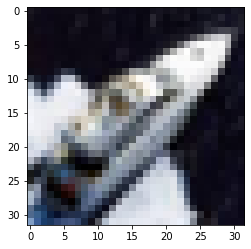

In [5]:
import matplotlib.pyplot as plt
idx = 20000
print(trans[y_train[idx][0]])
plt.imshow(x_train[idx])

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten

layers = [
    # 27(一個過濾器) = 3 * 3(9格) * 3(前一層通道數)
    # 27 * 64(64個過濾器) + 64(bias) = 1792
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(),
    # 3 * 3 * 64(1 filter) * 128 + 128(bias) = 73856
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    # 3 * 3 * 128(1 filter) * 256 + 256(bias) = 295168
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(512, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation="relu"),
    # 128 * 10 + 10(bias) = 1290
    Dense(10, activation="softmax")
]
model = Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

In [7]:
# 前強後弱->後面我喜歡使用GAP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten

layers = [
    # 27(一個過濾器) = 3 * 3(9格) * 3(前一層通道數)
    # 27 * 64(64個過濾器) + 64(bias) = 1792
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(),
    # 3 * 3 * 64(1 filter) * 128 + 128(bias) = 73856
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    # 3 * 3 * 128(1 filter) * 256 + 256(bias) = 295168
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(512, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    GlobalAveragePooling2D(),
    Dense(10, activation="softmax")
]
model = Sequential(layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 256)       

In [8]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer=Adam(),
       metrics=["accuracy"])

In [9]:
# x
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

In [10]:
# 以前y是做one-hot encoding, 如果輸出是有幾千種幾萬種
# 輸出:3000 筆數: 50000 妳會有 50000 * 3000這麼多值
# 如果你這樣做, 妳會用掉一堆無謂的RAM, 
# 所以我們在上面直接使用sparse, 妳說5, 他內部就會幫你搞定每一個位置的輸出

In [11]:
# batch_size: 看多少筆做一次梯度下降(把所有筆的斜率做一個平均)
# epochs: 整份(60000筆)妳總共看幾次
# validation_split: 切出多少%作為我的測試資料(10%)
# 270調整: (60000 * 0.9) / 200 -> 270 
# loss/accuracy: 54000筆訓練資料
# val_loss/val_accuracy: 6000筆測試資料
# !!! 看val_loss平滑下來->epochs
# !!! 過擬合: 不要無腦訓練下去(train loss會變低), 但你對於沒看過資料表現的並不會比較好(val loss變高)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    ModelCheckpoint("cnn.h5", save_best_only=True),
    EarlyStopping(patience=5, restore_best_weights=True)
]
# 不想要進度條, verbose=2
model.fit(x_train_norm,
     y_train,
     batch_size=200,
     epochs=50,
     validation_split=0.1,
     callbacks=callbacks,
     verbose=2)

Epoch 1/50
225/225 - 18s - loss: 1.6743 - accuracy: 0.3772 - val_loss: 1.4424 - val_accuracy: 0.4844 - 18s/epoch - 80ms/step
Epoch 2/50
225/225 - 4s - loss: 1.2270 - accuracy: 0.5609 - val_loss: 1.0849 - val_accuracy: 0.6250 - 4s/epoch - 19ms/step
Epoch 3/50
225/225 - 4s - loss: 1.0116 - accuracy: 0.6424 - val_loss: 0.8988 - val_accuracy: 0.6944 - 4s/epoch - 18ms/step
Epoch 4/50
225/225 - 4s - loss: 0.8671 - accuracy: 0.6989 - val_loss: 0.8420 - val_accuracy: 0.7100 - 4s/epoch - 19ms/step
Epoch 5/50
225/225 - 4s - loss: 0.7464 - accuracy: 0.7402 - val_loss: 0.7530 - val_accuracy: 0.7420 - 4s/epoch - 19ms/step
Epoch 6/50
225/225 - 4s - loss: 0.6566 - accuracy: 0.7715 - val_loss: 0.7356 - val_accuracy: 0.7468 - 4s/epoch - 19ms/step
Epoch 7/50
225/225 - 4s - loss: 0.5856 - accuracy: 0.7967 - val_loss: 0.6753 - val_accuracy: 0.7688 - 4s/epoch - 19ms/step
Epoch 8/50
225/225 - 4s - loss: 0.5139 - accuracy: 0.8222 - val_loss: 0.6986 - val_accuracy: 0.7598 - 4s/epoch - 19ms/step
Epoch 9/50
225

In [13]:
# 用沒看過的一萬筆作最終評估
model.evaluate(x_test_norm, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.7017 - accuracy: 0.7704


[0.7017488479614258, 0.7703999876976013]

In [17]:
# 因為你要進其他的(sklearn, 畫圖)
# pre: 10000
# y_test: (10000, 1) -> 10000
y_test = y_test.reshape(10000)

In [19]:
import pandas as pd
from sklearn.metrics import confusion_matrix
pre = model.predict(x_test_norm).argmax(axis=1)
# y注意一下: tensorflow裡:y_train_cat 出了tensorflow:帶原本y_train
mat = confusion_matrix(y_test, pre)
pd.DataFrame(mat,
      columns=["{}(predict)".format(trans[i]) for i in range(10)],
      index=["{}(true)".format(trans[i]) for i in range(10)])

,airplane(predict),automobile(predict),bird(predict),cat(predict),deer(predict),dog(predict),frog(predict),horse(predict),ship(predict),truck(predict)
airplane(true),902,7,7,5,10,4,9,4,43,9
automobile(true),22,894,3,8,3,1,7,1,27,34
bird(true),120,5,582,50,77,55,78,13,13,7
cat(true),40,17,44,577,53,164,67,12,19,7
deer(true),28,4,35,48,772,36,48,19,10,0
dog(true),26,5,21,124,42,722,22,19,15,4
frog(true),13,2,19,37,18,11,886,2,11,1
horse(true),41,5,29,48,77,69,3,715,5,8
ship(true),65,18,5,6,7,3,3,0,889,4
truck(true),62,97,6,19,4,5,7,4,31,765


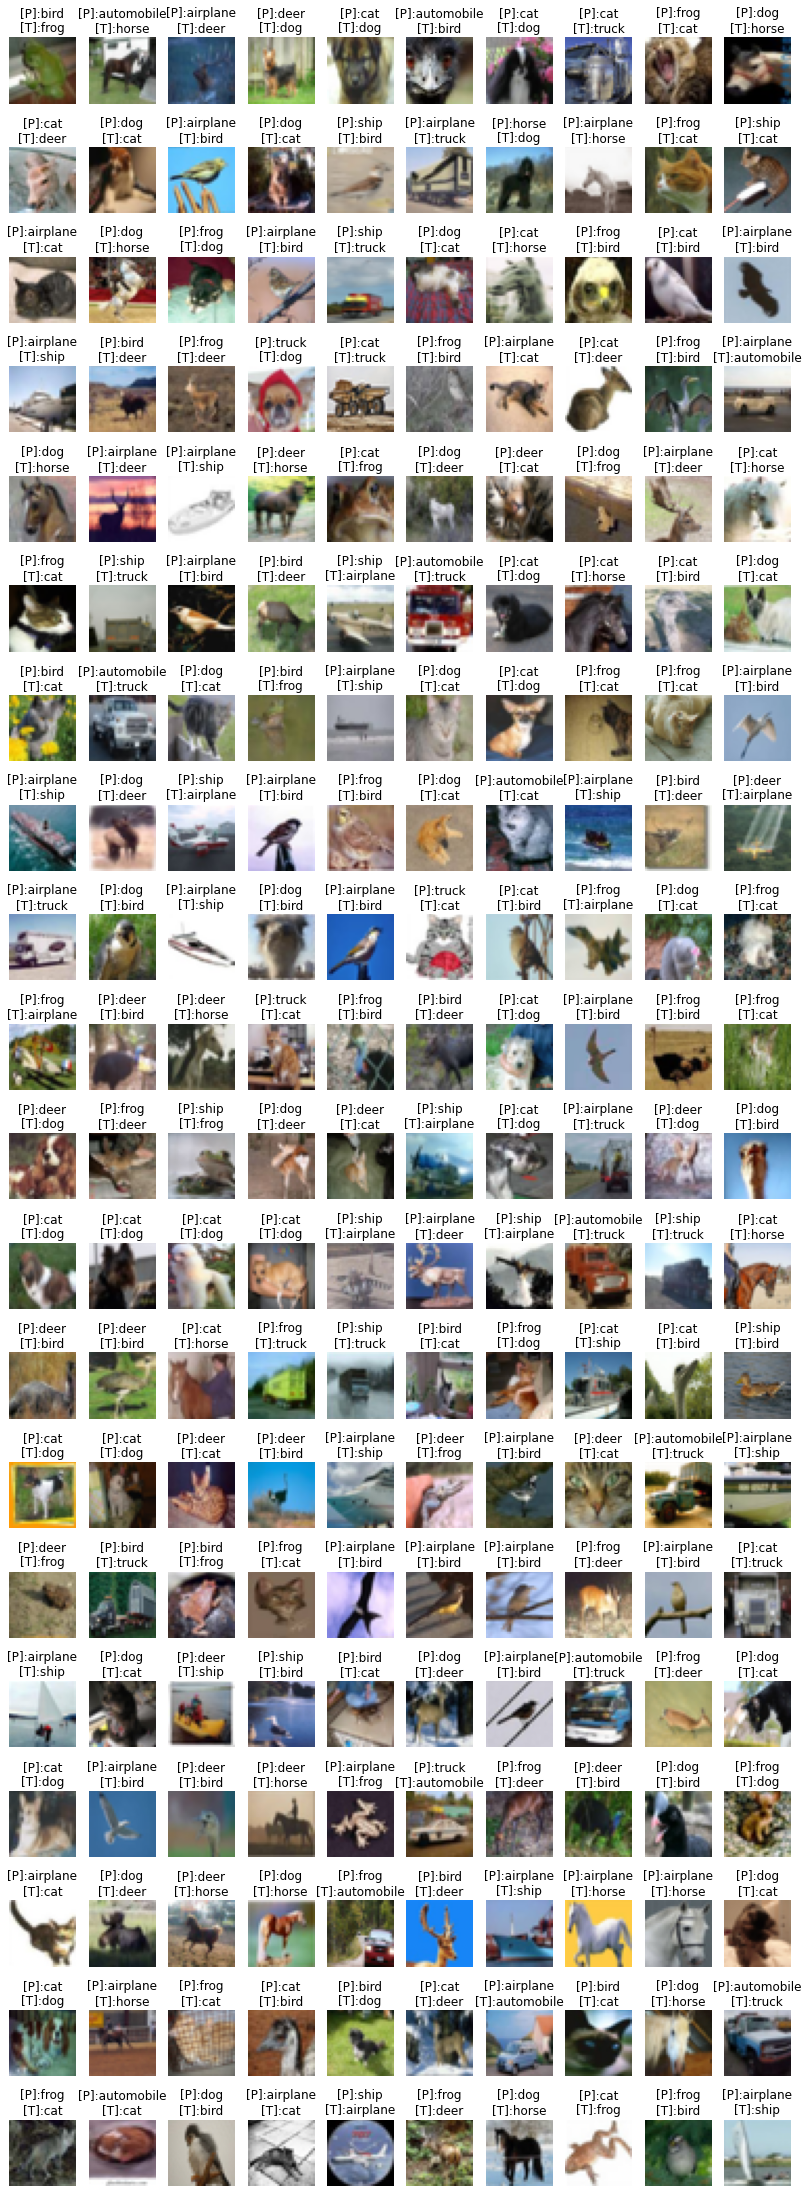

In [21]:
# subplot(總高度, 總寬度, ith[1,2,3])
# (2, 3, 1) (2, 3, 2) (2, 3, 3)
# (2, 3, 4) (2, 3, 5) (2, 3, 6)
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(14, 42))

idx = np.nonzero(pre != y_test)[0]
# 取前兩百筆就好
idx = idx[:200]
false_pre = pre[idx]
false_true = y_test[idx]
false_img = x_test[idx]

width = 10
height = len(idx) // width + 1

for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    title = "[P]:{}\n[T]:{}".format(trans[false_pre[i]], 
                     trans[false_true[i]])
    plt.title(title)
    plt.axis("off")
    plt.imshow(false_img[i])